In [73]:
import os
import sys
import argparse
import numpy as np
import torch
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm
import torch.nn as nn
import ants
import json

In [15]:
def pred_invert_resample(path_to_pred, path_to_orig, path_to_resampled):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
    if np.shape(data)[0] == 1:
        data = data.transpose(0,3,2,1).astype('float32')
        old_orig = ants.image_read(path_to_resampled)
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
        output_file = new_img.numpy().astype('float16')
    
    # gbm and lgg
    elif np.shape(data)[0] > 1:
        data = data.transpose(0,3,2,1).astype('float32')

        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)

        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])

        new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1, False, 0)
        new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1, False, 0)
        new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1, False, 0)

        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.transpose(0,3,2,1).astype('float16')
    return (output_file)

def pred_invert_resample_1cl(data, path_to_orig, path_to_resampled):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
        data = data.transpose(0,3,2,1).astype('float32')
        old_orig = ants.image_read(path_to_resampled)
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
        output_file = new_img.numpy().astype('float16')
        return (output_file)
    
def pred_invert_resample_classes(data, path_to_orig, path_to_resampled):

    # gbm and lgg
        data = data.transpose(0,3,2,1).astype('float32')

        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)

        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])

        new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1, False, 0)
        new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1, False, 0)
        new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1, False, 0)

        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.transpose(0,3,2,1).astype('float16')
        return (output_file)

In [37]:
pred_sub = '/results/schw_infer/schw_4a_resamp/predictions_best_epoch=88-dice_mean=89_45_task=39_fold=0_tta/VS-SEG-001.npy.npz'
orig_sub = '/data_anvar/public_datasets/preproc_study/schw/orig/VS-SEG-001/T1_SEG.nii.gz'
resamp_sub = '/data_anvar/public_datasets/preproc_study/schw/4a_resamp/VS-SEG-001/T1_SEG.nii.gz'
out_file = pred_invert_resample(pred_sub, orig_sub, resamp_sub)

In [38]:
out_file.shape

(512, 512, 120)

In [21]:
! cd /data_anvar/public_datasets/preproc_study/schw/4a_resamp/VS-SEG-001/ && ls

T1.nii.gz  T1_SEG.nii.gz  T2.nii.gz


In [ ]:
i_t = nib.load('/data/private_data/schw/schw_4a_resamp/labels/VS-SEG-001_seg.nii.gz')

In [20]:
def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)

In [26]:
def calculate_metrics_brats_1cl(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids','Dice_1'
                'Hausdorff95_1',
                'Sensitivity_1',
               'Specificity_1',
               'Surface_dice_1',
               'Precision_1']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask==1), (pred_mask==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    return df

def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
                'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
               'Specificity_1', 'Specificity_2', 'Specificity_3',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
               'Precision_1', 'Precision_2', 'Precision_3']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    #class 2
    distances = metrics.compute_surface_distances((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1), spaces)
    df.at[0,'Dice_2'] = metrics.compute_dice_coefficient((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Surface_dice_2'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    sens,precision, spec= sensitivity_and_specificity((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Sensitivity_2'] = sens
    df.at[0,'Precision_2'] = precision
    df.at[0,'Specificity_2'] = spec
    #class 3
    distances = metrics.compute_surface_distances((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1), spaces)
    df.at[0,'Dice_3'] = metrics.compute_dice_coefficient((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Surface_dice_3'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_3'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec= sensitivity_and_specificity((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Sensitivity_3'] = sens
    df.at[0,'Precision_3'] = precision
    df.at[0,'Specificity_3'] = spec
    return df

In [188]:
    
def calculate_metrics(subjects, path_to_orig, path_to_pred, path_to_resamp, path_to_target, dataset, out = '/home/polina/glioma/all_dice_metrics.csv'  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
#     _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
#                 'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
#                 'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
#                'Specificity_1', 'Specificity_2', 'Specificity_3',
#                'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
#                'Precision_1', 'Precision_2', 'Precision_3']
    _columns = ['Ids','Dice_1'
                'Hausdorff95_1',
                'Sensitivity_1',
               'Specificity_1',
               'Surface_dice_1',
               'Precision_1']
    
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    orig_folder = Path(path_to_orig)
    resamp_folder = Path(path_to_resamp)
    target_folder = Path(path_to_target)
    for ids in tqdm(subjects):
#         print(ids)
        pred_sub = os.path.join(pred_folder, ids + '.npy.npz')
        orig_sub = os.path.join(orig_folder, ids,'T1_SEG.nii.gz')
        resamp_sub = os.path.join(resamp_folder, ids,'T1_SEG.nii.gz')
#         targets = nib.load(os.path.join(target_folder, ids + '_seg.nii.gz'))
#         targets = ants.image_read(orig_sub)
#         targets = ants.reorient_image2(label_orig, orientation = 'LAI')
#         targets = nib.load(orig_sub)
#         spaces = targets.header.get_zooms()
#         spaces = targets.spacing
#         targets = targets.numpy().astype('int')
        targets = ants.image_read(f'{target_folder}/{ids}_seg.nii.gz')
        spaces = targets.spacing
        targets = ants.reorient_image2(targets, orientation = 'LAI').numpy()
#         print(targets.shape)
#         print(np.unique(targets))
        data = np.load(pred_sub, allow_pickle=True)['arr_0']
#         print(data.shape)
        if np.shape(data)[0] == 1: 
            prediction = pred_invert_resample_1cl(data, orig_sub, resamp_sub)
            prediction = np.round(prediction, 0)
#         pred = np.transpose(pred, (0, 3, 2, 1))
#             print(prediction.shape)
#             print(np.unique(prediction))
            df = calculate_metrics_brats_1cl(targets.astype('int'), prediction.astype('int'), ids, spaces)
#             print(df)
        elif np.shape(data)[0] > 1: 
            prediction = pred_invert_resample_classes(data, orig_sub, resamp_sub)[np.newaxis, :,:,:]
            y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
            targets = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)
            df=calculate_metrics_brats(targets.astype('int'), prediction.astype('int'), sub, spaces)
        os.makedirs(os.path.join(out, dataset,ids), exist_ok = True)
        out_path = os.path.join(out, dataset,ids, path_to_pred.split('/')[-2] + '_'+ path_to_pred.split('best_')[-1].replace('=', '_') + '.json')
       #         df.to_json(out_path, orient='records')
        sub_dict = {dataset : {path_to_pred.split('/')[-2]: {path_to_pred.split('_')[-2]: {}}}}
        sub_dict[dataset][path_to_pred.split('/')[-2]][path_to_pred.split('_')[-2]] = df.to_dict('records')[0]
#         print(sub_dict)
        with open(out_path, 'w') as fp:
            json.dump(sub_dict, fp)
#         print(df)
        af_all = af_all.append(df)
#     af_all.to_csv(out)  
    print(af_all.mean())
    

In [189]:
subjects = [each[:-8] for each in os.listdir(pred_folder)]

In [190]:
orig_folder = '/data_anvar/public_datasets/preproc_study/schw/orig'
resample_folder = '/data_anvar/public_datasets/preproc_study/schw/4a_resamp'
pred_folder = '/results/schw_infer/schw_4d_susan/predictions_best_epoch=92-dice_mean=89_37_task=42_fold=0_tta'
target_folder = '/data/private_data/schw/schw_1_reg/labels'
reg_1 = '/data_anvar/public_datasets/preproc_study/schw/1_reg'
out_json = '/results/metrics'
dataset = 'schw'
subjects = [each[:-8] for each in os.listdir(pred_folder)]
calculate_metrics(subjects, orig_folder, pred_folder, resample_folder, target_folder, dataset, out = out_json)

 14%|██████████████████████▊                                                                                                                                       | 35/242 [03:12<18:44,  5.43s/it]/tmp/ipykernel_28215/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [22:37<00:00,  5.61s/it]

Dice_1Hausdorff95_1         NaN
Sensitivity_1          0.183198
Specificity_1          0.999995
Surface_dice_1         0.113845
Precision_1            0.892078
Dice_1                 0.277241
Hausdorff95_1               inf
dtype: float64


In [196]:
orig_folder = '/data_anvar/public_datasets/preproc_study/schw/orig'
resample_folder = '/data_anvar/public_datasets/preproc_study/schw/4a_resamp'
pred_folder = '/results/schw_infer/schw_4d_susan/predictions_best_epoch=92-dice_mean=91_10_task=42_fold=1_tta'
target_folder = '/data/private_data/schw/schw_1_reg/labels'
reg_1 = '/data_anvar/public_datasets/preproc_study/schw/1_reg'
out_json = '/results/metrics'
dataset = 'schw'
subjects = [each[:-8] for each in os.listdir(pred_folder)]
calculate_metrics(subjects, orig_folder, pred_folder, resample_folder, target_folder, dataset, out = out_json)

  2%|██▋                                                                                                                                                            | 4/242 [00:21<21:11,  5.34s/it]/tmp/ipykernel_28215/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [22:50<00:00,  5.66s/it]

Dice_1Hausdorff95_1         NaN
Sensitivity_1          0.317411
Specificity_1          1.000000
Surface_dice_1         0.304043
Precision_1            0.999804
Dice_1                 0.440201
Hausdorff95_1               inf
dtype: float64


In [ ]:
orig_folder = '/data_anvar/public_datasets/preproc_study/schw/orig'
resample_folder = '/data_anvar/public_datasets/preproc_study/schw/4a_resamp'
pred_folder = '/results/schw_infer/schw_4d_susan/predictions_best_epoch=86-dice_mean=88_69_task=42_fold=2_tta'
target_folder = '/data/private_data/schw/schw_1_reg/labels'
reg_1 = '/data_anvar/public_datasets/preproc_study/schw/1_reg'
out_json = '/results/metrics'
dataset = 'schw'
subjects = [each[:-8] for each in os.listdir(pred_folder)]
calculate_metrics(subjects, orig_folder, pred_folder, resample_folder, target_folder, dataset, out = out_json)

In [195]:
orig_folder = '/data_anvar/public_datasets/preproc_study/schw/orig'
resample_folder = '/data_anvar/public_datasets/preproc_study/schw/4a_resamp'
pred_folder = '/results/schw_infer/schw_4b_n4/predictions_best_epoch=87-dice_mean=89_45_task=41_fold=0_tta'
target_folder = '/data/private_data/schw/schw_1_reg/labels'
reg_1 = '/data_anvar/public_datasets/preproc_study/schw/1_reg'
out_json = '/results/metrics'
dataset = 'schw'
subjects = [each[:-8] for each in os.listdir(pred_folder)]
calculate_metrics(subjects, orig_folder, pred_folder, resample_folder, target_folder, dataset, out = out_json)

 40%|███████████████████████████████████████████████████████████████▉                                                                                              | 98/242 [09:15<13:34,  5.66s/it]/tmp/ipykernel_28215/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [22:31<00:00,  5.58s/it]

Dice_1Hausdorff95_1         NaN
Sensitivity_1          0.348096
Specificity_1          0.999999
Surface_dice_1         0.336086
Precision_1            0.978247
Dice_1                 0.483173
Hausdorff95_1               inf
dtype: float64


In [ ]:
orig_folder = '/data_anvar/public_datasets/preproc_study/schw/orig'
resample_folder = '/data_anvar/public_datasets/preproc_study/schw/4a_resamp'
pred_folder = '/results/schw_infer/schw_4b_n4/predictions_best_epoch=97-dice_mean=91_28_task=41_fold=1_tta'
target_folder = '/data/private_data/schw/schw_1_reg/labels'
reg_1 = '/data_anvar/public_datasets/preproc_study/schw/1_reg'
out_json = '/results/metrics'
dataset = 'schw'
subjects = [each[:-8] for each in os.listdir(pred_folder)]
calculate_metrics(subjects, orig_folder, pred_folder, resample_folder, target_folder, dataset, out = out_json)

In [ ]:
orig_folder = '/data_anvar/public_datasets/preproc_study/schw/orig'
resample_folder = '/data_anvar/public_datasets/preproc_study/schw/4a_resamp'
pred_folder = '/results/schw_infer/schw_4b_n4/predictions_best_epoch=95-dice_mean=89_05_task=41_fold=2_tta'
target_folder = '/data/private_data/schw/schw_1_reg/labels'
reg_1 = '/data_anvar/public_datasets/preproc_study/schw/1_reg'
out_json = '/results/metrics'
dataset = 'schw'
subjects = [each[:-8] for each in os.listdir(pred_folder)]
calculate_metrics(subjects, orig_folder, pred_folder, resample_folder, target_folder, dataset, out = out_json)

In [1]:
!ls

Untitled.ipynb	gbm_metrics.ipynb  metrics.py


In [241]:
out_json = '/results/metrics/schw/'
dataset = 'schw'
task = 'schw_4a_resamp'
fold = 'fold_0'
dice = []
hausdorff = []
sensitivity = []
specificity = []
surface_dice = []
precision = []
_columns = ['Ids','Dice_1'
                'Hausdorff95_1',
                'Sensitivity_1',
               'Specificity_1',
               'Surface_dice_1',
               'Precision_1'] 
metrics_all = pd.DataFrame(columns = _columns)
for sub in os.listdir(out_json):
    for sub_t in os.listdir(os.path.join(out_json, sub)):
        if task in sub_t:
            if fold in sub_t:
                print(os.path.join(out_json, sub, sub_t))
                metrics = json.load(open(os.path.join(out_json, sub, sub_t)))
                metrics = metrics[dataset][task][fold.replace('_', '=')]
                for each in metrics:
                    metrics_all[each]
                    
                af_all = af_all.append(df)
                dice.append(metrics['Dice_1'])
                hausdorff.append(metrics['Hausdorff95_1'])
                sensitivity.append(metrics['Sensitivity_1'])
                specificity.append(metrics['Specificity_1'])
                surface_dice.append(metrics['Surface_dice_1'])
                precision.append(metrics['Precision_1'])


/results/metrics/schw/VS-SEG-191/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json
/results/metrics/schw/VS-SEG-108/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json
/results/metrics/schw/VS-SEG-073/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json
/results/metrics/schw/VS-SEG-050/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json
/results/metrics/schw/VS-SEG-062/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json
/results/metrics/schw/VS-SEG-031/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json
/results/metrics/schw/VS-SEG-096/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json
/results/metrics/schw/VS-SEG-111/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json
/results/metrics/schw/VS-SEG-166/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json
/results/metrics/schw/VS-SEG-021/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json
/results/metrics/schw/VS-SEG-0

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 20: invalid start byte

In [ ]:
data = data.transpose(0,3,2,1).astype('float32')
old_orig = ants.image_read(path_to_resampled)
new_orig = ants.image_read(path_to_orig)
old_like = old_orig.new_image_like(data[0])
new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
output_file = new_img.numpy().astype('float16')

(512, 512, 120)
(512, 512, 120)
[0 1]


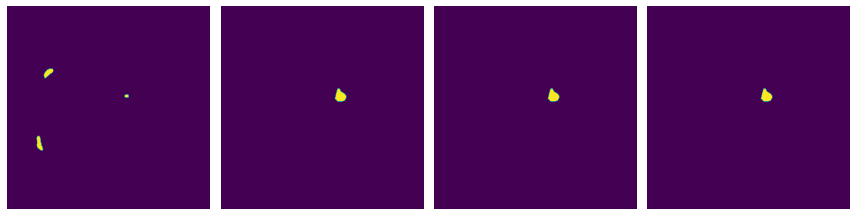

0.03782937646751892
0.005505371400821127


In [199]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
#  VS-SEG-002_seg.nii.gz
sub = 'VS-SEG-004'
n, z = 1, 80
for i in range(n):
    pred_sub = f'/results/schw_infer/schw_4d_susan/predictions_best_epoch=92-dice_mean=89_37_task=42_fold=0_tta/{sub}.npy.npz'
    orig_folder = f'/data_anvar/public_datasets/preproc_study/schw/orig/{sub}/T1_SEG.nii.gz'
    resample_folder = f'/data_anvar/public_datasets/preproc_study/schw/4a_resamp/{sub}/T1_SEG.nii.gz'
    reg_1 = f'/data_anvar/public_datasets/preproc_study/schw/1_reg/{sub}/T1_SEG.nii.gz'
    targets = ants.image_read(f'/data/private_data/schw/schw_1_reg/labels/{sub}_seg.nii.gz')
    targets = ants.reorient_image2(targets, orientation = 'LAI').numpy().astype('int')
    print(targets.shape)
    data = np.load(pred_sub, allow_pickle=True)['arr_0']
    prediction = pred_invert_resample_1cl(data, reg_1, resample_folder)
    prediction = np.round(prediction, 0).astype('int')
    print(prediction.shape), print(np.unique(prediction))
    label_k = ants.image_read(f'/data_anvar/public_datasets/preproc_study/schw/1_reg_check/{sub}/T1_SEG.nii.gz')
    label_k = ants.reorient_image2(label_k, orientation = 'LAI').numpy().astype('int')
#     label_k = nib.load('/data_anvar/public_datasets/preproc_study/schw/1_reg_check/VS-SEG-157/T1_SEG.nii.gz').get_fdata().astype('int')
#     label_p = nib.load('/data/private_data/schw/schw_1_reg/labels/VS-SEG-157_seg.nii.gz').get_fdata().astype('int')
    label_orig = ants.image_read(orig_folder)
    label_orig = ants.reorient_image2(label_orig, orientation = 'LAI').numpy().astype('int')
#     label_orig = nib.load(orig_folder).get_fdata().astype('int')
    z = np.argsort(label_k.sum(axis=(0,1)))[-1:]
    
    imgs = [prediction[:, :, z]]  + [label_k[:, :, z]] + [label_orig[:,:,z]] + [targets[:,:,z]] 
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
    for i in range(4):
        ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()
    
print(metrics.compute_dice_coefficient((targets==1), (prediction==1)))
distances = metrics.compute_surface_distances((targets==1), (prediction==1), [1,1,1])
print(metrics.compute_surface_dice_at_tolerance(distances,1))

(1, 210, 210, 180)
[0 1]


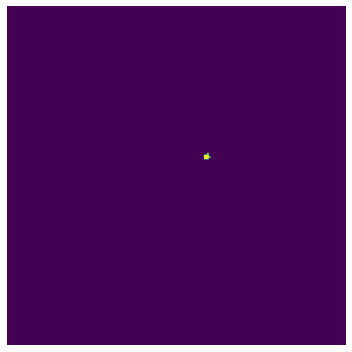

In [53]:
pred_sub = f'/results/schw_infer/schw_4a_resamp/predictions_best_epoch=88-dice_mean=89_45_task=39_fold=0_tta/{sub}.npy.npz'
data = np.load(pred_sub, allow_pickle=True)['arr_0']
data = data.transpose(0,3,2,1).astype('float32')
data = np.round(data, 0).astype('int')
# z = np.argsort(data.sum(axis=(0,1)))[-1:]
print(data.shape), print(np.unique(data))
imgs = [data[0,:,:,z][0]]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.imshow(imgs[0]);
ax.axis('off')  
plt.tight_layout()            
plt.show()  

(210, 210, 180)


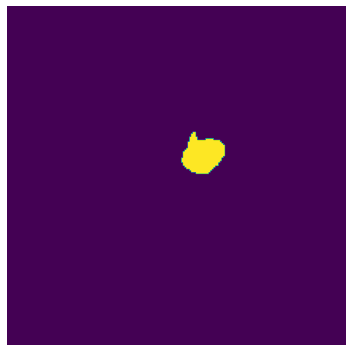

In [52]:
resamp = ants.image_read('/data_anvar/public_datasets/preproc_study/schw/4a_resamp/VS-SEG-157/T1_SEG.nii.gz').numpy().astype('int')
z = np.argsort(resamp.sum(axis=(0,1)))[-1:]
print(resamp.shape)
imgs = [resamp[:,:,z]]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.imshow(imgs[0]);
ax.axis('off')  
plt.tight_layout()            
plt.show()    

(512, 512, 120)


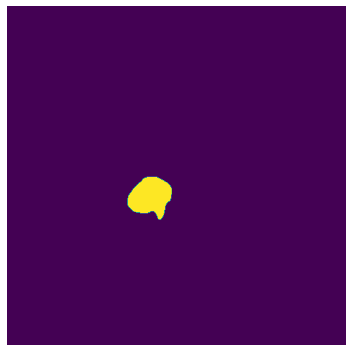

In [15]:
resamp = ants.image_read('/data_anvar/public_datasets/preproc_study/schw/1_reg/VS-SEG-157/T1_SEG.nii.gz').numpy().astype('int')
z = np.argsort(resamp.sum(axis=(0,1)))[-1:]
print(resamp.shape)
imgs = [resamp[:,:,z]]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.imshow(imgs[0]);
ax.axis('off')  
plt.tight_layout()            
plt.show()  

(512, 512, 120)


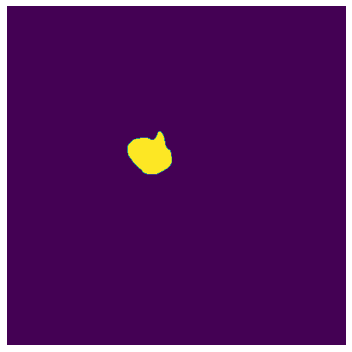

In [16]:
resamp = ants.image_read('/data_anvar/public_datasets/preproc_study/schw/orig/VS-SEG-157/T1_SEG.nii.gz').numpy().astype('int')
z = np.argsort(resamp.sum(axis=(0,1)))[-1:]
print(resamp.shape)
imgs = [resamp[:,:,z]]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.imshow(imgs[0]);
ax.axis('off')  
plt.tight_layout()            
plt.show() 

In [19]:
resamp = ants.image_read('/data_anvar/public_datasets/preproc_study/schw/1_reg/VS-SEG-157/T1_SEG.nii.gz')
resamp

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 512, 120)
	 Spacing    : (0.4102, 0.4102, 1.5)
	 Origin     : (-110.5344, 82.9941, -79.1036)
	 Direction  : [ 1. -0.  0. -0. -1.  0.  0.  0.  1.]

In [17]:
resamp = ants.image_read('/data_anvar/public_datasets/preproc_study/schw/orig/VS-SEG-157/T1_SEG.nii.gz')
resamp

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 512, 120)
	 Spacing    : (0.4102, 0.4102, 1.5)
	 Origin     : (99.0554, 82.9941, -79.1036)
	 Direction  : [-1. -0.  0.  0. -1.  0.  0.  0.  1.]

In [10]:
resamp = ants.image_read('/data_anvar/public_datasets/preproc_study/schw/4a_resamp/VS-SEG-157/T1_SEG.nii.gz')
resamp

ANTsImage (LAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (210, 210, 180)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (99.0554, -126.5958, -79.1036)
	 Direction  : [-1.  0.  0.  0.  1.  0.  0.  0.  1.]

In [1]:
! cd /data_anvar/public_datasets/preproc_study/schw/1_reg_check/VS-SEG-157 && ls 

VS-SEG-157  VS-SEG-239	logging.txt


In [76]:
#     subjects = ['VS-SEG-001']
#     orig_folder = '/data_anvar/public_datasets/preproc_study/schw/orig'
#     resample_folder = '/data_anvar/public_datasets/preproc_study/schw/4a_resamp'
#     pred_folder = '/results/schw_infer/schw_4a_resamp/predictions_best_epoch=88-dice_mean=89_45_task=39_fold=0_tta'
#     target_folder = '/data/private_data/schw/schw_1_reg/labels'
#     reg_1 = '/data_anvar/public_datasets/preproc_study/schw/1_reg'
#     out_json = '/results/metrics'
#     dataset = 'schw'
#     calculate_metrics(subjects, reg_1, pred_folder, resample_folder, target_folder, dataset, out = out_json)

In [77]:
!python metrics.py --path_to_pred /results/schw_infer/schw_4a_resamp/predictions_best_epoch=88-dice_mean=89_45_task=39_fold=0_tta --path_to_1_reg  /data_anvar/public_datasets/preproc_study/schw/1_reg --path_to_target /data/private_data/schw/schw_1_reg/labels --path_to_resamp /data_anvar/public_datasets/preproc_study/schw/4a_resamp --dataset schw 

Untitled.ipynb	metrics.py


(512, 512, 120)
(512, 512, 120)
[0 1]


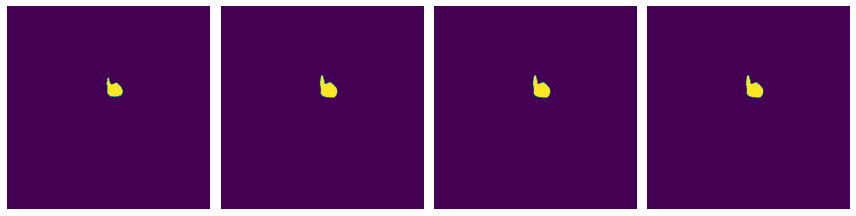

0.8491934123995278
0.9132080041248442


In [212]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
#  VS-SEG-002_seg.nii.gz
sub = 'VS-SEG-003'
n, z = 1, 80
for i in range(n):
    pred_sub = f'/results/schw_infer/schw_4a_resamp/predictions_best_epoch=128-dice_mean=91_84_task=39_fold=1_tta/{sub}.npy.npz'
    orig_folder = f'/data_anvar/public_datasets/preproc_study/schw/orig/{sub}/T1_SEG.nii.gz'
    resample_folder = f'/data_anvar/public_datasets/preproc_study/schw/4a_resamp/{sub}/T1_SEG.nii.gz'
    reg_1 = f'/data_anvar/public_datasets/preproc_study/schw/1_reg/{sub}/T1_SEG.nii.gz'
    targets = ants.image_read(f'/data/private_data/schw/schw_1_reg/labels/{sub}_seg.nii.gz')
    targets = ants.reorient_image2(targets, orientation = 'LAI').numpy().astype('int')
    print(targets.shape)
    data = np.load(pred_sub, allow_pickle=True)['arr_0']
    prediction = pred_invert_resample_1cl(data, reg_1, resample_folder)
    prediction = np.round(prediction, 0).astype('int')
    print(prediction.shape), print(np.unique(prediction))
    label_k = ants.image_read(f'/data_anvar/public_datasets/preproc_study/schw/1_reg_check/{sub}/T1_SEG.nii.gz')
    label_k = ants.reorient_image2(label_k, orientation = 'LAI').numpy().astype('int')
#     label_k = nib.load('/data_anvar/public_datasets/preproc_study/schw/1_reg_check/VS-SEG-157/T1_SEG.nii.gz').get_fdata().astype('int')
#     label_p = nib.load('/data/private_data/schw/schw_1_reg/labels/VS-SEG-157_seg.nii.gz').get_fdata().astype('int')
    label_orig = ants.image_read(orig_folder)
    label_orig = ants.reorient_image2(label_orig, orientation = 'LAI').numpy().astype('int')
#     label_orig = nib.load(orig_folder).get_fdata().astype('int')
    z = np.argsort(label_k.sum(axis=(0,1)))[-1:]
    
    imgs = [prediction[:, :, z]]  + [label_k[:, :, z]] + [label_orig[:,:,z]] + [targets[:,:,z]] 
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
    for i in range(4):
        ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()
    
print(metrics.compute_dice_coefficient((targets==1), (prediction==1)))
distances = metrics.compute_surface_distances((targets==1), (prediction==1), [1,1,1])
print(metrics.compute_surface_dice_at_tolerance(distances,1))

(512, 512, 120)
(512, 512, 120)
[0 1]


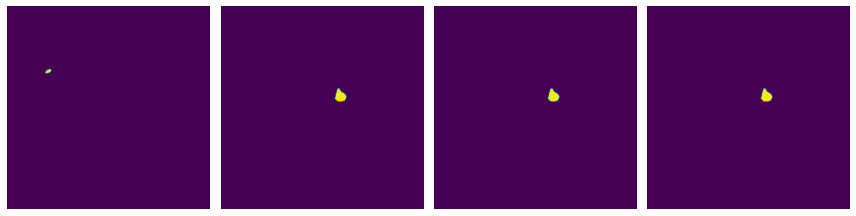

0.0
0.0


In [213]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
#  VS-SEG-002_seg.nii.gz
sub = 'VS-SEG-004'
n, z = 1, 80
for i in range(n):
    pred_sub = f'/results/schw_infer/schw_4a_resamp/predictions_best_epoch=128-dice_mean=91_84_task=39_fold=1_tta/{sub}.npy.npz'
    orig_folder = f'/data_anvar/public_datasets/preproc_study/schw/orig/{sub}/T1_SEG.nii.gz'
    resample_folder = f'/data_anvar/public_datasets/preproc_study/schw/4a_resamp/{sub}/T1_SEG.nii.gz'
    reg_1 = f'/data_anvar/public_datasets/preproc_study/schw/1_reg/{sub}/T1_SEG.nii.gz'
    targets = ants.image_read(f'/data/private_data/schw/schw_1_reg/labels/{sub}_seg.nii.gz')
    targets = ants.reorient_image2(targets, orientation = 'LAI').numpy().astype('int')
    print(targets.shape)
    data = np.load(pred_sub, allow_pickle=True)['arr_0']
    prediction = pred_invert_resample_1cl(data, reg_1, resample_folder)
    prediction = np.round(prediction, 0).astype('int')
    print(prediction.shape), print(np.unique(prediction))
    label_k = ants.image_read(f'/data_anvar/public_datasets/preproc_study/schw/1_reg_check/{sub}/T1_SEG.nii.gz')
    label_k = ants.reorient_image2(label_k, orientation = 'LAI').numpy().astype('int')
#     label_k = nib.load('/data_anvar/public_datasets/preproc_study/schw/1_reg_check/VS-SEG-157/T1_SEG.nii.gz').get_fdata().astype('int')
#     label_p = nib.load('/data/private_data/schw/schw_1_reg/labels/VS-SEG-157_seg.nii.gz').get_fdata().astype('int')
    label_orig = ants.image_read(orig_folder)
    label_orig = ants.reorient_image2(label_orig, orientation = 'LAI').numpy().astype('int')
#     label_orig = nib.load(orig_folder).get_fdata().astype('int')
    z = np.argsort(label_k.sum(axis=(0,1)))[-1:]
    
    imgs = [prediction[:, :, z]]  + [label_k[:, :, z]] + [label_orig[:,:,z]] + [targets[:,:,z]] 
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
    for i in range(4):
        ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()
    
print(metrics.compute_dice_coefficient((targets==1), (prediction==1)))
distances = metrics.compute_surface_distances((targets==1), (prediction==1), [1,1,1])
print(metrics.compute_surface_dice_at_tolerance(distances,1))

[54]


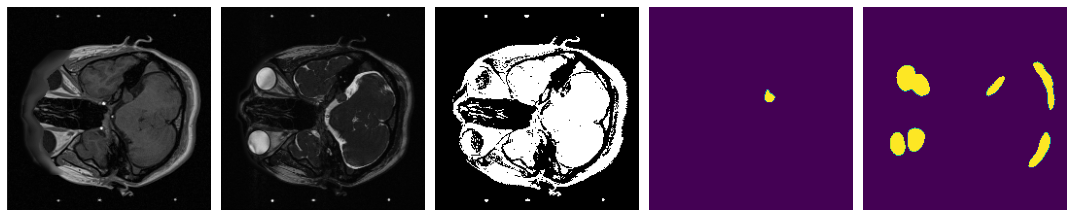

In [227]:
from scipy.special import expit, softmax
import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
fname = 'VS-SEG-004'
img_orig = np.load(f"/data/private_data/schw/39_3d/{fname}_x.npy").transpose(3,2,1,0)
label_orig = np.load(f"/data/private_data/schw/39_3d/{fname}_y.npy").transpose(0,3,2,1).squeeze()
l = np.argsort(label_orig.sum(axis=(0,1)))[-1:]
print(l)
pred = np.load(f'/results/schw_infer/schw_4a_resamp/predictions_best_epoch=2-dice_mean=5_32_task=39_fold=0_tta/{fname}.npy.npz')['arr_0']
p = np.round(pred, 0).transpose(3,2,1,0).astype(np.uint8)

imgs = [img_orig[:, :, l, i] for i in [0,1,2]] + [label_orig[:,:,l]]  +[p[:,:,l,0]] 
 
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i in range(5):
        if i < 3:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
plt.tight_layout()            
plt.show()

[48]


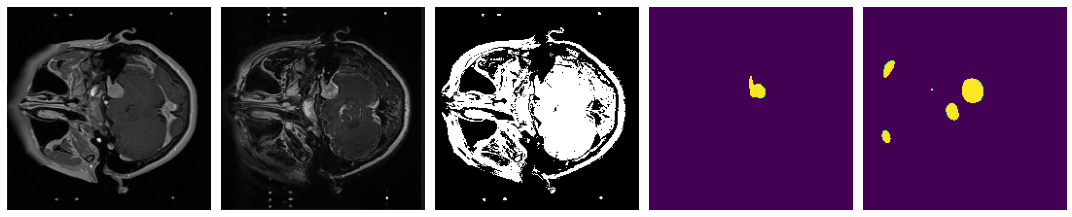

In [229]:
from scipy.special import expit, softmax
import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
fname = 'VS-SEG-003'
img_orig = np.load(f"/data/private_data/schw/39_3d/{fname}_x.npy").transpose(3,2,1,0)
label_orig = np.load(f"/data/private_data/schw/39_3d/{fname}_y.npy").transpose(0,3,2,1).squeeze()
l = np.argsort(label_orig.sum(axis=(0,1)))[-1:]
print(l)
pred = np.load(f'/results/schw_infer/schw_4a_resamp/predictions_best_epoch=2-dice_mean=5_32_task=39_fold=0_tta/{fname}.npy.npz')['arr_0']
p = np.round(pred, 0).transpose(3,2,1,0).astype(np.uint8)

imgs = [img_orig[:, :, l, i] for i in [0,1,2]] + [label_orig[:,:,l]]  +[p[:,:,l,0]] 
 
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i in range(5):
        if i < 3:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
plt.tight_layout()            
plt.show()

In [225]:
len(os.listdir('/results/schw_infer/schw_4a_resamp/predictions_best_epoch=128-dice_mean=91_84_task=39_fold=1_tta/'))

242

In [243]:
!export CUDA_VISIBLE_DEVICES=1 && python3 ../main.py --exec_mode evaluate --task 39_3d --data /data/private_data/schw/39_3d --no_back_in_output --dim 3 --fold 1 --nfolds 3 --ckpt_path /results/schw_results/schw_4a_resamp_debug/fold-0/checkpoints/best*.ckpt --results /results/schw_infer_debug/schw_4a_resamp --amp --tta --save_preds

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
python3: can't open file '../main.py': [Errno 2] No such file or directory


In [245]:
!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
